In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Import required libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
# Change directory to your desired path
os.chdir('/content/drive/MyDrive/bm')

In [ ]:
# Load the dataset
df = pd.read_csv('transformed_data.csv')
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (50418, 9)
  CODE      COUNTRY        DATE    HDI   TC   TD  STI        POP    GDPCAP
0  AFG  Afghanistan  2019-12-31  0.498  0.0  0.0  0.0  17.477233  7.497754
1  AFG  Afghanistan  2020-01-01  0.498  0.0  0.0  0.0  17.477233  7.497754
2  AFG  Afghanistan  2020-01-02  0.498  0.0  0.0  0.0  17.477233  7.497754
3  AFG  Afghanistan  2020-01-03  0.498  0.0  0.0  0.0  17.477233  7.497754
4  AFG  Afghanistan  2020-01-04  0.498  0.0  0.0  0.0  17.477233  7.497754


In [ ]:
# Task 1: Exploratory Data Analysis (EDA)
# ----------------------------------------
# 1.1 Dataset Description
print("\nDataset Description:")
print("Columns:", df.columns.tolist())
print("Target variable distribution:\n", df['TC'].value_counts())
print("\nSummary Statistics:\n", df.describe())


Dataset Description:
Columns: ['CODE', 'COUNTRY', 'DATE', 'HDI', 'TC', 'TD', 'STI', 'POP', 'GDPCAP']
Target variable distribution:
 TC
0.000000     4235
1.098612      512
2.564949      441
2.397895      412
2.890372      392
             ... 
10.028003       1
10.045855       1
10.104385       1
10.123907       1
9.005405        1
Name: count, Length: 19171, dtype: int64

Summary Statistics:
                 HDI            TC            TD           STI           POP  \
count  44216.000000  50418.000000  50418.000000  50418.000000  50418.000000   
mean       0.720139      6.762125      3.413681      3.178897     15.442097   
std        0.160902      3.637347      3.082761      1.673451      2.495039   
min        0.000000      0.000000      0.000000      0.000000      6.695799   
25%        0.601000      4.158883      0.000000      2.867331     14.151619   
50%        0.752000      7.092574      3.178054      4.000583     15.929201   
75%        0.847000      9.504669      5.620401   

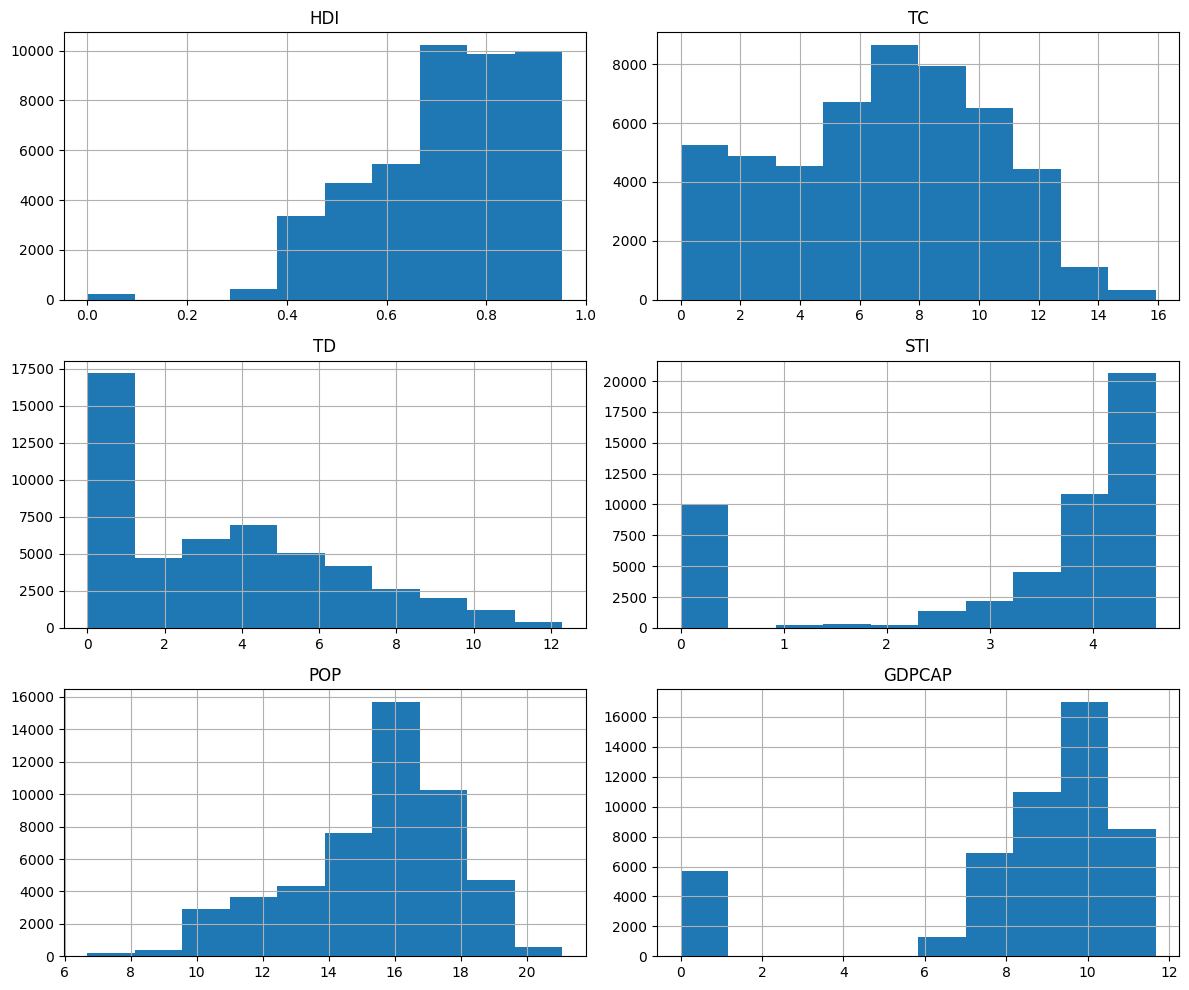

In [ ]:
# 1.2 Data Visualization
# Histograms
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

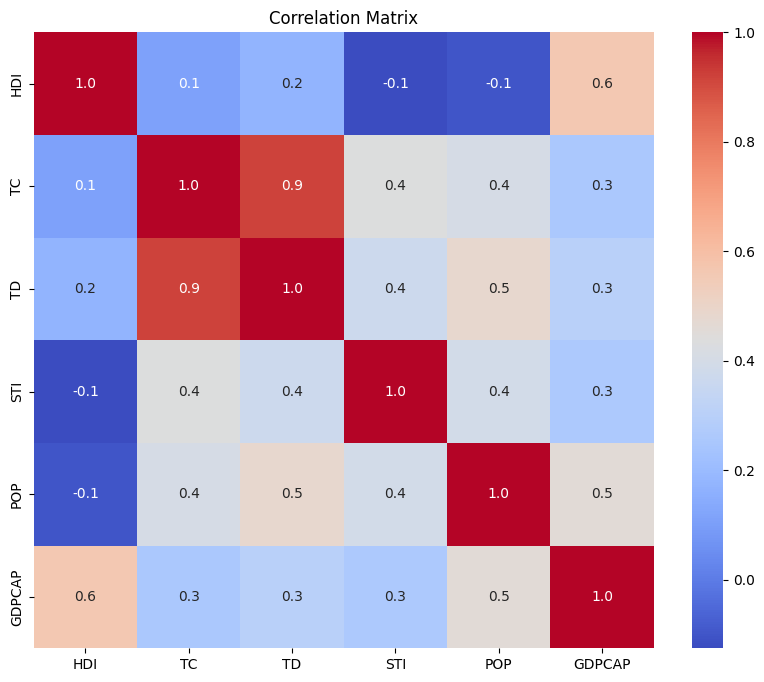

In [ ]:
# Correlation matrix for numerical features only
plt.figure(figsize=(10, 8))
numerical_df = df.select_dtypes(include=np.number) # Select only numerical columns
sns.heatmap(numerical_df.corr(), annot=True, fmt=".1f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

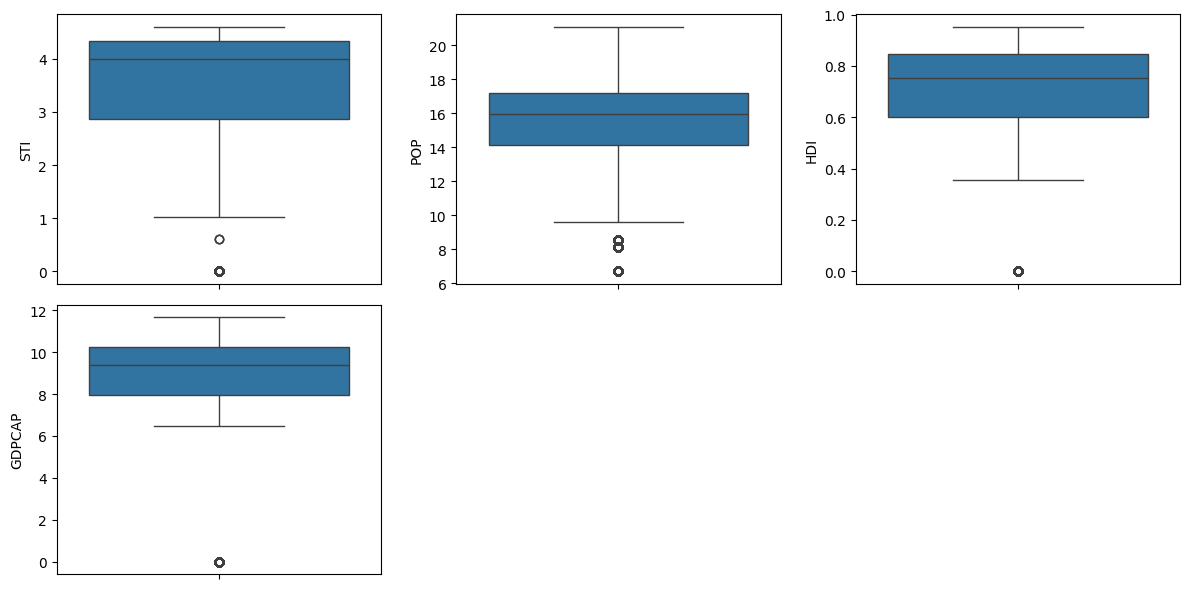

In [ ]:
# Boxplots for numerical features
numerical_features = ['STI', 'POP', 'HDI', 'GDPCAP']
plt.figure(figsize=(12, 6))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
plt.tight_layout()
plt.show()

In [ ]:

# Task 2: Build Logistic Regression from Scratch
# ----------------------------------------------
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.lr = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iter):
            linear = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear)
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear)
        return (y_pred >= 0.5).astype(int)

In [ ]:
# Prepare data for custom model
X = df[['TD', 'STI', 'POP', 'HDI', 'GDPCAP']].values # Select numerical features only
y = df['TC'].values

# Assuming 'TC' should be binary, convert it:
y = (y > 0).astype(int)  # Convert 'TC' to 0 or 1 based on a threshold (e.g., > 0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train and evaluate custom model
custom_model = CustomLogisticRegression()
custom_model.fit(X_train, y_train)
y_pred_train = custom_model.predict(X_train)
y_pred_test = custom_model.predict(X_test)

print("\nCustom Logistic Regression Metrics:")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))


Custom Logistic Regression Metrics:
Train Accuracy: 0.08534512070724243
Test Accuracy: 0.08085415840275023


In [ ]:
# Task 3: Build Primary Models
# ----------------------------
# Split data for sklearn models
X_train_sk, X_test_sk, y_train_sk, y_test_sk = train_test_split(
    df[['TD', 'STI', 'POP', 'HDI', 'GDPCAP']],  # Select only numerical features
    df['TC'],
    test_size=0.3,
    random_state=42
)

# This replaces NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_train_sk = imputer.fit_transform(X_train_sk)
X_test_sk = imputer.transform(X_test_sk)

# Convert the target variable to discrete classes if it's continuous
# Assuming you want to classify based on whether 'TC' is greater than 0
y_train_sk = (y_train_sk > 0).astype(int)
y_test_sk = (y_test_sk > 0).astype(int)

# Model 1: Sklearn Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_sk, y_train_sk)
y_pred_lr = lr.predict(X_test_sk)

# Model 2: Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_sk, y_train_sk)
y_pred_rf = rf.predict(X_test_sk)

# Evaluate models
def print_metrics(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-Score:", f1_score(y_true, y_pred))

print_metrics(y_test_sk, y_pred_lr, "Logistic Regression")
print_metrics(y_test_sk, y_pred_rf, "Random Forest")



Logistic Regression Metrics:
Accuracy: 0.9568293005421129
Precision: 0.9714631369200114
Recall: 0.9818744155937568
F1-Score: 0.9766410302271508

Random Forest Metrics:
Accuracy: 0.9837366124553748
Precision: 0.9907999712499101
Recall: 0.9915126231748543
F1-Score: 0.9911561691113029


In [ ]:
# Task 4: Hyperparameter Tuning
# -----------------------------
# Logistic Regression Tuning
param_grid_lr = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}
grid_lr = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid_lr, cv=5)
grid_lr.fit(X_train_sk, y_train_sk)
print("\nBest Parameters for Logistic Regression:", grid_lr.best_params_)

# Random Forest Tuning
param_grid_rf = {'n_estimators': [50, 100], 'max_depth': [None, 5, 10]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
grid_rf.fit(X_train_sk, y_train_sk)
print("Best Parameters for Random Forest:", grid_rf.best_params_)


Best Parameters for Logistic Regression: {'C': 1, 'penalty': 'l1'}
Best Parameters for Random Forest: {'max_depth': None, 'n_estimators': 50}


In [ ]:
# Task 5: Feature Selection
# --------------------------
numerical_features = df.select_dtypes(include=np.number).drop('TC', axis=1)

# Impute missing values before feature selection
imputer = SimpleImputer(strategy='mean') # Create an imputer to fill NaN values
numerical_features_imputed = imputer.fit_transform(numerical_features) # Apply the imputer

selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(numerical_features_imputed, df['TC']) # Use imputed data

# Get selected feature names
selected_features = numerical_features.columns[selector.get_support()]
print("\nSelected Features:", selected_features.tolist())


Selected Features: ['HDI', 'TD', 'STI', 'POP', 'GDPCAP']


In [ ]:
# Task 6: Final Model
# -------------------
# Rebuild models with selected features and best parameters
X_train_final = selector.transform(X_train_sk)
X_test_final = selector.transform(X_test_sk)

# Logistic Regression with tuned params
lr_final = LogisticRegression(**grid_lr.best_params_, solver='liblinear')
lr_final.fit(X_train_final, y_train_sk)
y_pred_lr_final = lr_final.predict(X_test_final)

# Random Forest with tuned params
rf_final = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
rf_final.fit(X_train_final, y_train_sk)
y_pred_rf_final = rf_final.predict(X_test_final)

# Evaluate final models
print_metrics(y_test_sk, y_pred_lr_final, "Tuned Logistic Regression")
print_metrics(y_test_sk, y_pred_rf_final, "Tuned Random Forest")


Tuned Logistic Regression Metrics:
Accuracy: 0.9574904138569351
Precision: 0.9714834305219742
Recall: 0.9825936848162267
F1-Score: 0.9770069730019667

Tuned Random Forest Metrics:
Accuracy: 0.9836705011238926
Precision: 0.9907287623975851
Recall: 0.9915126231748543
F1-Score: 0.9911205378006255


In [ ]:
# prompt: Do all this from scratch with all code

from google.colab import drive
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif

drive.mount('/content/drive')

# Change directory to your desired path
os.chdir('/content/drive/MyDrive/bm')

# Load the dataset
df = pd.read_csv('transformed_data.csv')
print("Dataset shape:", df.shape)
print(df.head())

# ... (rest of your code)
